In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split

import torchvision
from torchvision import transforms
from torchvision import models


import cv2

import os
from math import log10

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset and DataLoaders

In [2]:
ROOT_IMAGE_PATH = '/home/ubuntu/data/super-resolution/converted_images'
#ROOT_IMAGE_PATH = '/Users/ar660763/data/super-resolution/converted_images'

DEV = False
dev_train_size = 100
dev_val_size = 20
    
transform_img=None
# transform_img = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(0,1)
# ])

class SuperResDataset(Dataset):
    def __init__(self, root_images_folder_path, transform=None, is_train=False, dev_train_size=None, dev_val_size=None):
        super().__init__()
        self.root_images_folder_path = root_images_folder_path
        self.transform = transform
        self.is_train = is_train
        sorted_filenames_small = sorted(os.listdir(self.root_images_folder_path + '/small'))
        sorted_filenames_med = sorted(os.listdir(self.root_images_folder_path + '/med'))
        sorted_filenames_large = sorted(os.listdir(self.root_images_folder_path + '/large'))
        if is_train:
            if dev_train_size:
                self.image_files_small = sorted_filenames_small[1000:1000+dev_train_size]
                self.image_files_med = sorted_filenames_med[1000:1000+dev_train_size]
                self.image_files_large = sorted_filenames_large[1000:1000+dev_train_size]
            else:    
                self.image_files_small = sorted_filenames_small[1000:]
                self.image_files_med = sorted_filenames_med[1000:]
                self.image_files_large = sorted_filenames_large[1000:]
        else:
            if dev_val_size:
                self.image_files_small = sorted_filenames_small[:dev_val_size]
                self.image_files_med = sorted_filenames_med[:dev_val_size]
                self.image_files_large = sorted_filenames_large[:dev_val_size]
            else:    
                self.image_files_small = sorted_filenames_small[:1000]
                self.image_files_med = sorted_filenames_med[:1000]
                self.image_files_large = sorted_filenames_large[:1000]
        
    def __len__(self):
        return len(self.image_files_small)
    
    def __getitem__(self,idx):
        filenames = {}
        filenames['small'] = self.image_files_small[idx]
        filenames['med'] = self.image_files_med[idx]
        filenames['large'] = self.image_files_large[idx]
        
        image_path = os.path.join(self.root_images_folder_path + '/small', self.image_files_small[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        if not self.transform is None:
            img = self.transform(img)
        img_small = np.transpose(img,(2,0,1))
        
        
        image_path = os.path.join(self.root_images_folder_path + '/med', self.image_files_med[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        if not self.transform is None:
            img = self.transform(img)
        img_med = np.transpose(img,(2,0,1))

        image_path = os.path.join(self.root_images_folder_path + '/large', self.image_files_large[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        if not self.transform is None:
            img = self.transform(img)
        img_large = np.transpose(img,(2,0,1))
        
        return filenames,img_small,img_med,img_large    
    

if DEV:
    train_ds = SuperResDataset(ROOT_IMAGE_PATH, transform=transform_img, is_train=True, dev_train_size=dev_train_size, dev_val_size=dev_val_size)
    val_ds = SuperResDataset(ROOT_IMAGE_PATH, transform=transform_img, is_train=False, dev_train_size=dev_train_size, dev_val_size=dev_val_size)        
else:    
    train_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=True)
    val_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=False)


print(len(train_ds), len(val_ds))

tr_loader = DataLoader(train_ds, batch_size=5)
val_loader = DataLoader(val_ds, batch_size=1)

#val_ds[0]



4011 1000


## Functions to show images

In [3]:
def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    #plt.show()

def show_3_images(labels,img1, img2, img3):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    show_img(img1)
    plt.title(labels[0])
    plt.subplot(1,3,2)
    show_img(img2)
    plt.title(labels[1])
    plt.subplot(1,3,3)
    show_img(img3)
    plt.title(labels[2])
    plt.tight_layout()
    plt.show()
    
def show_4_images(labels,img1, img2, img3, img4):
    plt.figure(figsize=(14,8))
    plt.subplot(1,4,1)
    show_img(img1)
    plt.title(labels[0])
    plt.subplot(1,4,2)
    show_img(img2)
    plt.title(labels[1])
    plt.subplot(1,4,3)
    show_img(img3)
    plt.title(labels[2])
    plt.subplot(1,4,4)
    show_img(img4)
    plt.title(labels[3])
    plt.tight_layout()
    plt.show()  
    

torch.Size([1, 3, 72, 72])


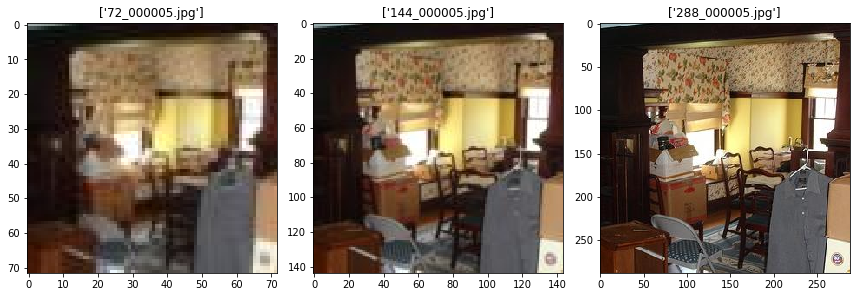

torch.Size([1, 3, 72, 72])


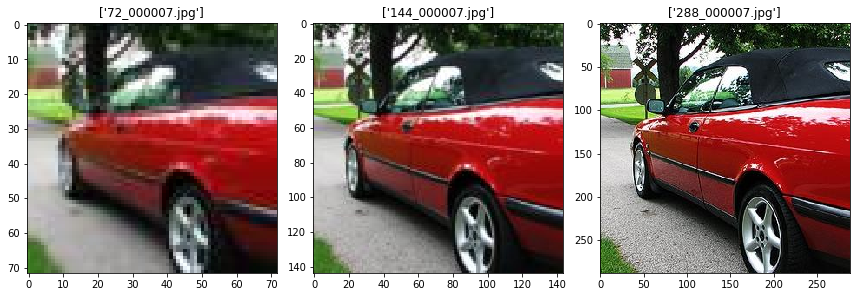

In [3]:
# Can print from the val loader    
for step,batch in enumerate(val_loader):
    filenames,img_small,img_med,img_large = batch
    print(img_small.shape)
    #print(filenames)
    #show_img(torch.squeeze(img_small))
    #show_img(torch.squeeze(img_med))
    #show_img(torch.squeeze(img_large))
    
    show_3_images([filenames['small'], filenames['med'], filenames['large']], torch.squeeze(img_small), torch.squeeze(img_med), torch.squeeze(img_large)   )
    #show_img(torch.squeeze(img))
    #print(torch.squeeze(img).shape)
    

## Models

In [24]:
vgg16_model = models.vgg16(pretrained=True)._modules['features']
vgg16_model
#models.vgg16(pretrained=True)._modules['features'][29]
#models.vgg16(pretrained=True).features[:29]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [14]:
# Step 6 - PreTrained Layer Model

class SuperResPreTrainedBlockNet(nn.Module):
    def __init__(self):
        super(SuperResPreTrainedBlockNet, self).__init__()
        # padding of 2 gives us the same size output as input => (72 + (2*1) - 3) + 1 = 72
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(size=(144,144))
        # For kernel size of 1 to keep same output size we use padding of 0 => (72 + (2*0) - 1) + 1 = 72
        self.conv3 = nn.Conv2d(in_channels=576, out_channels=3, kernel_size=1, padding=0)
        self.upsample2 = nn.UpsamplingBilinear2d(size=(288,288))
        self.conv4 = nn.Conv2d(in_channels=576, out_channels=3, kernel_size=1, padding=0)
        
        self.upsample_72 = nn.UpsamplingBilinear2d(size=(72,72))
        
        #self.vgg16_features = models.vgg16(pretrained=True).features[:29]
        self.vgg16_features = models.vgg16(pretrained=True)._modules['features'][:22]
        for param in self.vgg16_features.parameters():
            param.requires_grad = False    
        #self.vgg_features = models.vgg16(pretrained=True)._modules['features'][:29]
                        
    def forward(self, x):
        #print(f"x.shape: {x.shape}")
        c = f.leaky_relu(self.conv1(x))
        #print(f"x.shape: {x.shape}, c.shape: {c.shape}")
        c = f.leaky_relu(self.conv2(c))
        #print(f"x.shape: {x.shape}, c.shape: {c.shape}")
        pre_trained_features = self.vgg16_features(x)
        #print(f"pre_trained_features.shape: {pre_trained_features.shape}")
        pre_trained_features = self.upsample_72(pre_trained_features) # upsample the pretrained features so that they are same as input
        #print(f"pre_trained_features.shape: {pre_trained_features.shape}")
        
        concatenated_channels = torch.cat((c,pre_trained_features),1) # apply relu?
        #print(f"concatenated_channels.shape: {concatenated_channels.shape}")
        x = self.upsample1(concatenated_channels)
        x_288 = self.upsample2(x)
        #x_144 = f.leaky_relu(self.conv3(x))
        #x_288 = f.leaky_relu(self.conv4(x_288))
        x_144 = self.conv3(x)
        x_288 = self.conv4(x_288)

        return x_144,x_288
    
    

## Training

In [6]:
def train(tr_loader, val_loader, model, criterion, optimizer, num_epochs):
    training_log = [] # results for each of the epochs so that we have the log of what went on during training
    
    if torch.has_cuda:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu:0')
    
    print('Starting training...')

    # this can be done externally (to the function) as well
    if torch.has_cuda:
        print("Setting the model on cuda...")
        model.cuda()
        
    for epoch in range(num_epochs):     # training loop       

        # train 
        model.train()
        tr_loss = 0
        for step,batch in enumerate(tr_loader):
            filenames,imgs_small,imgs_med,imgs_large = batch
            #print(filenames)
            #print(imgs_small.shape)
            imgs_small = imgs_small.float()
            imgs_med = imgs_med.float()
            imgs_large = imgs_large.float()
            imgs_small = imgs_small.to(device) 
            imgs_med = imgs_med.to(device)
            imgs_large = imgs_large.to(device)
            # get imgs and targets into right format and onto device
            output_144, output_288 = model(imgs_small)
            #print("img_small:")
            #print(img_small)
            #print("output_144:")
            #print(output_144)
            #print(output_144.shape, output_288.shape, img_med.shape, img_large.shape)
            loss_144 = criterion(output_144,imgs_med)
            loss_288 = criterion(output_288,imgs_large)
            #print(loss_144 + loss_288)
            alpha = epoch/num_epochs
            loss = ((1-alpha)*loss_144 + alpha*loss_288)/2
            #loss = torch.add(1oss_144 + loss_288)
            #loss = criterion(outputs,imgs_med) # imgs_med is the target
            loss.backward()
            tr_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            #print('Finished batch: %d, training loss = %f' % (step,loss.item()))
            
        # eval
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None
        val_psnr_med = 0
        val_psnr_large = 0
        
        with torch.no_grad():
            for step,batch in enumerate(val_loader):
                filenames,imgs_small,imgs_med,imgs_large = batch
                imgs_small = imgs_small.float()
                imgs_med = imgs_med.float()
                imgs_large = imgs_large.float()
                imgs_small = imgs_small.to(device) 
                imgs_med = imgs_med.to(device)
                imgs_large = imgs_large.to(device)
                output_144, output_288 = model(imgs_small)
                loss_144 = criterion(output_144,imgs_med)
                loss_288 = criterion(output_288,imgs_large)
                alpha = epoch/num_epochs
                loss = ((1-alpha)*loss_144 + alpha*loss_288)/2
                #loss = (loss_144 + loss_288)
                
                mse_value = torch.mean((output_144 - imgs_med).pow(2))
                psnr_value_med = 20 * torch.log10(1. / torch.sqrt(mse_value))
                mse_value = torch.mean((output_288 - imgs_large).pow(2))
                psnr_value_large = 20 * torch.log10(1. / torch.sqrt(mse_value))
                
                #loss = criterion(outputs,imgs_med)
                val_loss += loss.item()
                val_psnr_med += psnr_value_med
                val_psnr_large += psnr_value_large

            # show an example image
            it = iter(val_loader)
            filenames,imgs_small,imgs_med,imgs_large = it.next()
            imgs_small = imgs_small.to(device) # needs to go to gpu as we are passing it to the model
            preds = model(imgs_small.float())
            imgs_small = imgs_small.cpu() # goes to cpu for display
            if torch.has_cuda:
                pred_med = preds[0].cpu() # goes to cpu for display
                pred_large = preds[1].cpu()
            else:
                pred_med = preds[0]
                pred_large = preds[1]
            #print(imgs_small)
            #print(model(imgs_small.float()))
            #print(model(imgs_small.float())/255)
            #print(pred)
            #show_3_images(['input', 'prediction', 'target'], torch.squeeze(imgs_small), torch.squeeze(pred/255), torch.squeeze(imgs_med))
            #show_3_images(['input', 'prediction', 'target'], torch.squeeze(imgs_small), torch.squeeze(pred), torch.squeeze(imgs_large))
            show_4_images(['input', 'prediction-mid', 'prediction-large', 'target'], \
                          torch.squeeze(imgs_small), torch.squeeze(pred_med), torch.squeeze(pred_large), torch.squeeze(imgs_large))
        
        
        print('Epoch: %d, training loss = %f, val loss = %f, PSNR_med = %f, PSNR_large = %f' % \
              (epoch, tr_loss / len(tr_loader), val_loss / len(val_loader), val_psnr_med/len(val_loader), val_psnr_large/len(val_loader) ))
             
          
          
          
        
        

Starting training...
Setting the model on cuda...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


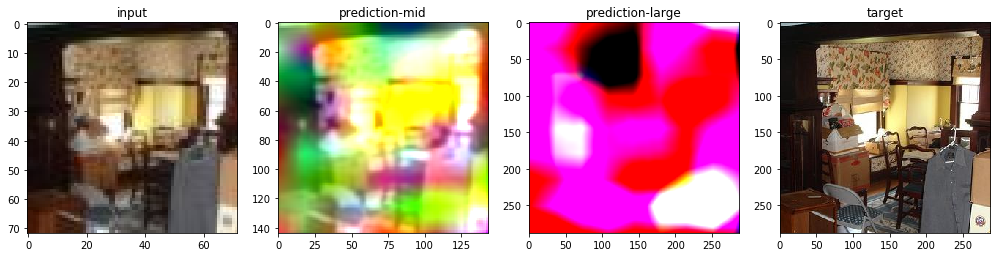

Epoch: 0, training loss = 0.282207, val loss = 0.117745, PSNR_med = 6.567325, PSNR_large = -9.842235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


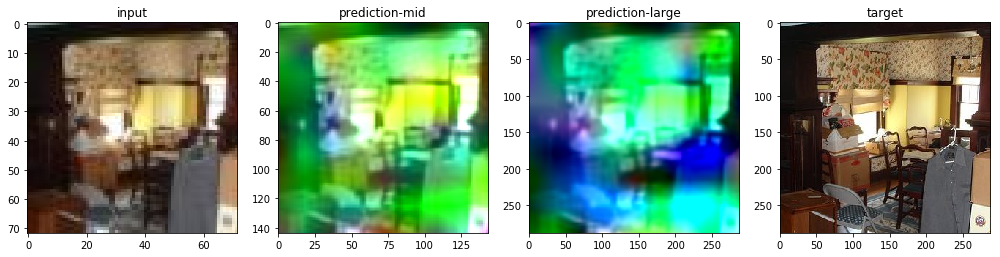

Epoch: 1, training loss = 0.064041, val loss = 0.061152, PSNR_med = 9.592653, PSNR_large = 7.665275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


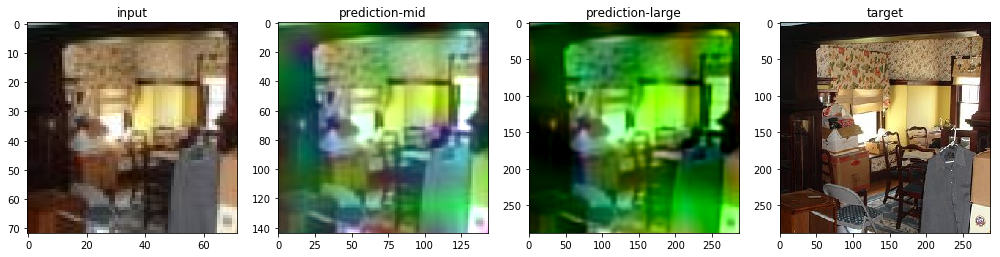

Epoch: 2, training loss = 0.023479, val loss = 0.026259, PSNR_med = 14.002358, PSNR_large = 10.463162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


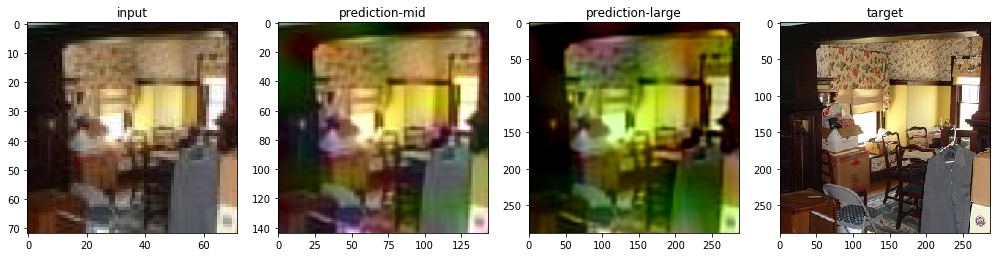

Epoch: 3, training loss = 0.016660, val loss = 0.011689, PSNR_med = 19.562986, PSNR_large = 13.259874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


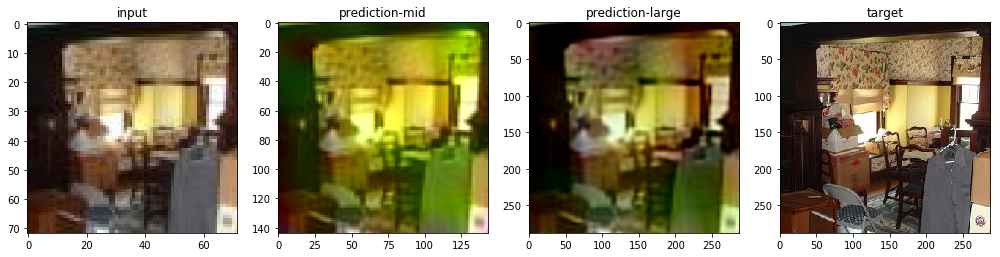

Epoch: 4, training loss = 0.017121, val loss = 0.017677, PSNR_med = 14.889821, PSNR_large = 14.978883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


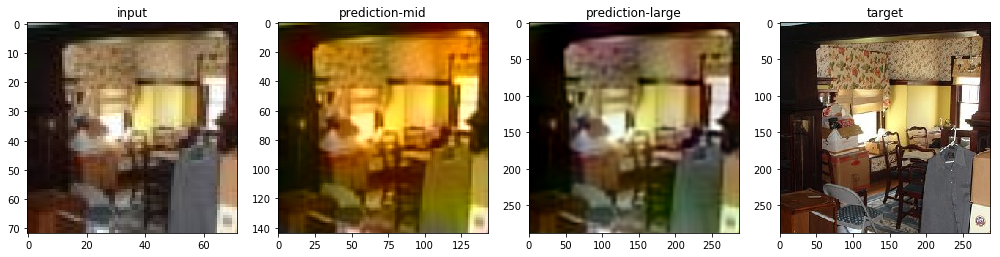

Epoch: 5, training loss = 0.015795, val loss = 0.014623, PSNR_med = 14.145992, PSNR_large = 18.595879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


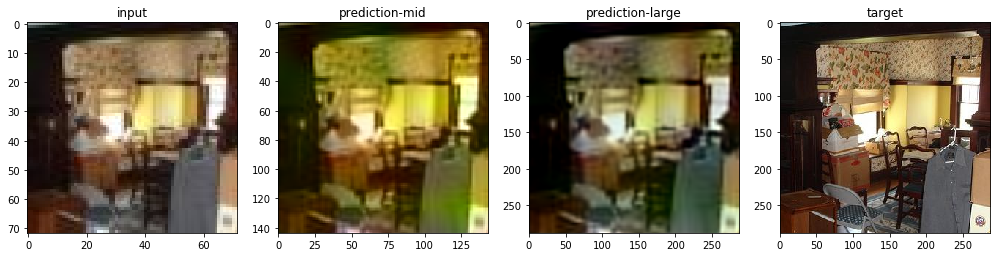

Epoch: 6, training loss = 0.014761, val loss = 0.009398, PSNR_med = 17.828386, PSNR_large = 17.464973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


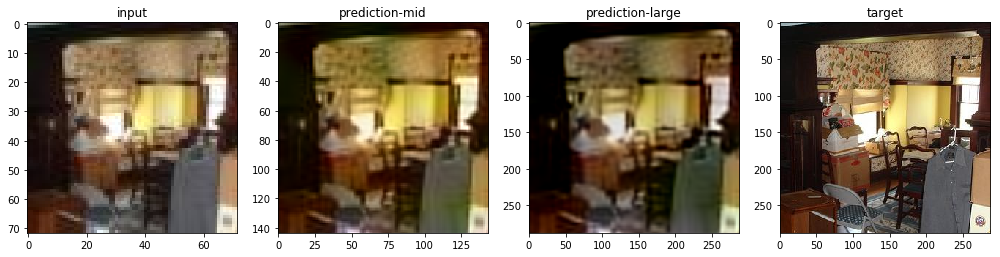

Epoch: 7, training loss = 0.018380, val loss = 0.010324, PSNR_med = 20.525333, PSNR_large = 16.294456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


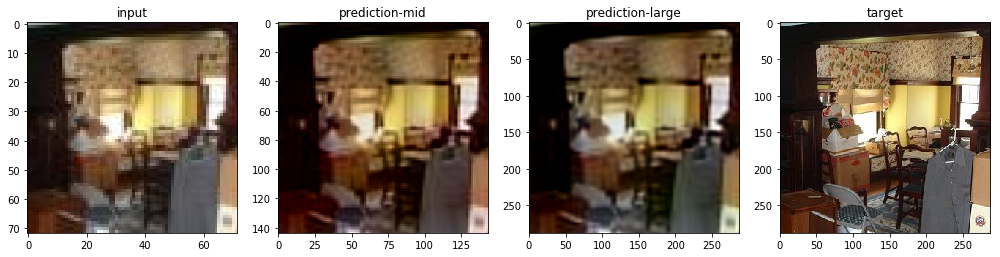

Epoch: 8, training loss = 0.016532, val loss = 0.010843, PSNR_med = 17.898071, PSNR_large = 16.788979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


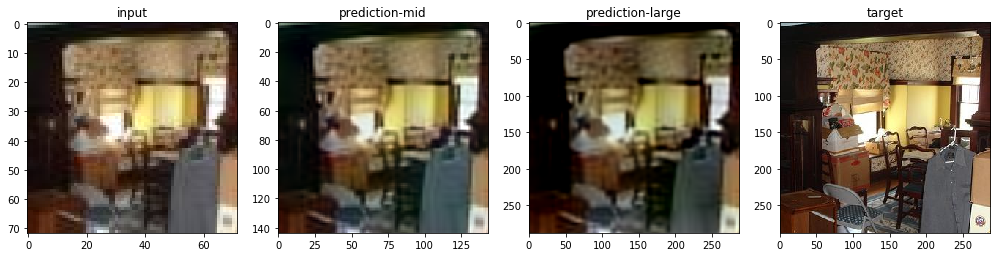

Epoch: 9, training loss = 0.018405, val loss = 0.012578, PSNR_med = 22.406830, PSNR_large = 16.007816
CPU times: user 13min 38s, sys: 3min 44s, total: 17min 23s
Wall time: 15min 42s


In [16]:
%%time

num_epochs = 10
# if torch.has_cuda:
#     device = torch.device('cuda:0')
# else:
#     device = torch.device('cpu:0')

#criterion = nn.CrossEntropyLoss()
#criterion = nn.SmoothL1Loss() # L1Loss()  # not sure what loss function to use
criterion = nn.MSELoss()   # not sure what loss function to use
model = SuperResPreTrainedBlockNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    
train(tr_loader, val_loader, model, criterion, optimizer, num_epochs)

    

